## Домашнее задание «Поиск изменений во временном ряде»
Преподаватель: Наталья Баданина

Выберите ряд, на котором происходит аномалия. Паримените к нему все 4 способа поиска анамолий


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from collections import deque
from collections import defaultdict

import matplotlib.font_manager
from sklearn import svm

from detectors import simulate, MeanDetector, ZScoreDetector, detect_cusum

plt.rcParams['figure.figsize'] = (16, 5)

In [2]:
# https://www.kaggle.com/nphantawee/pump-sensor-data?select=sensor.csv
series = pd.read_csv('../../../sensor.csv')['sensor_02'].dropna().values

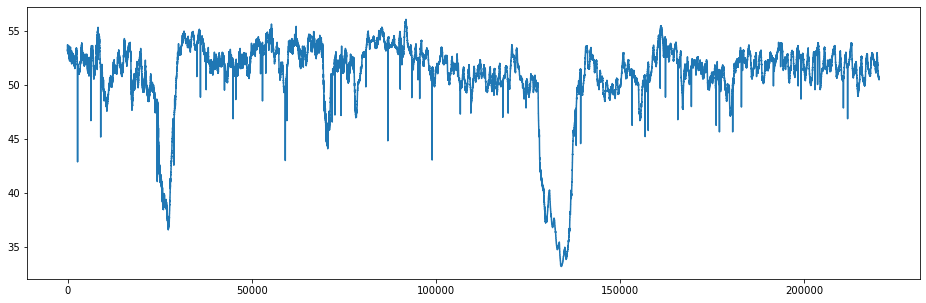

In [3]:
plt.plot(series);

In [4]:
series.size

220301

### 1. Простое мат ожидание

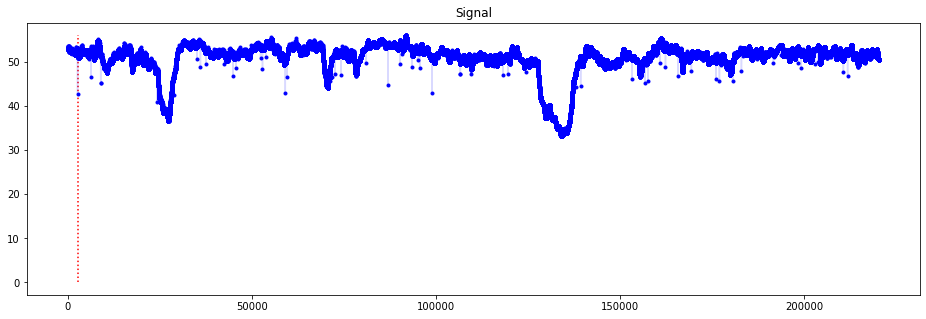

In [5]:
simulate(MeanDetector(threshold=0.05), series)

Метод хорошо реагирует на выбросы, но не на более глобальные изменения

### 2. Потоковые окна

/media/dmi/5F9CFB7847A8B8FE/netology/ML/anomaly/detectors.py:75: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
/media/dmi/5F9CFB7847A8B8FE/netology/ML/anomaly/detectors.py:78: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE
/media/dmi/5F9CFB7847A8B8FE/netology/ML/anomaly/detectors.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
/media/dmi/5F9CFB7847A8B8FE/netology/ML/anomaly/detectors.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


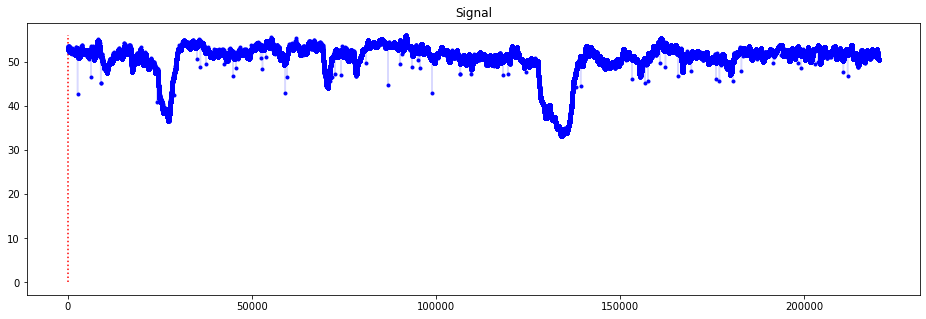

In [6]:
simulate(ZScoreDetector(window_size=5_000, threshold=5.0), series)

### 3. Кумулятивные суммы

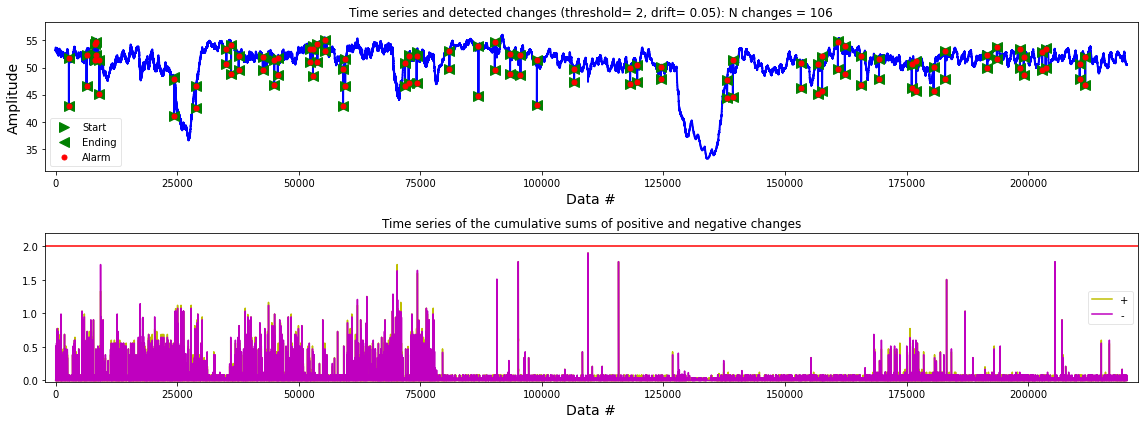

In [26]:
ta, tai, taf, amp = detect_cusum(series, 2, 0.05, True, True)

хорошо предсказываются выбросы

### 4. OneClass SVM

In [95]:
sig1_noise = series.reshape(-1, 1)
split = series.size  // 2
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(sig1_noise[:split])

y_pred_train = clf.predict(sig1_noise[:split])
y_pred_test = clf.predict(sig1_noise[split:])

In [96]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, sig1_noise[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, sig1_noise[idx]))

In [97]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


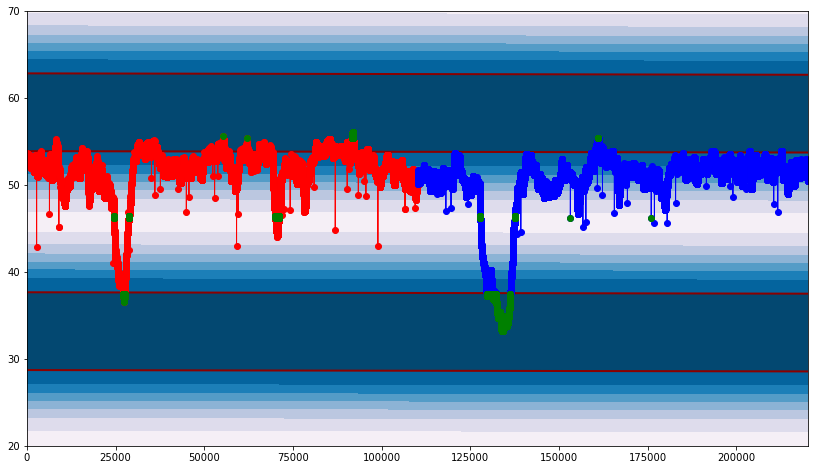

In [98]:
y = np.linspace(20, 70, 150).reshape(-1, 1)
Z = clf.decision_function(y)
Z = np.hstack((Z, Z))
y = y.reshape(150)

plt.figure(figsize=(14,8))
plt.contourf([0, sig1_noise.shape[0]], y, Z.reshape(150, 2), cmap=plt.cm.PuBu)
plt.contour([0, sig1_noise.shape[0]], y, Z.reshape(150, 2), levels=[0], linewidths=2, colors='darkred')
plt.plot(range(split), sig1_noise[:split], 'ro', linewidth=2)
plt.plot(range(split), sig1_noise[:split], 'r-', linewidth=1)
plt.plot(range(split,sig1_noise.shape[0]), sig1_noise[split:], 'bo', linewidth=2)
plt.plot(range(split,sig1_noise.shape[0]), sig1_noise[split:], 'b-', linewidth=1)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show();

SVM хорошо предсказывает выбросы, 
Достаточно хорошо предсказан "провал" между 125000 и 150000